In [1]:
import numpy as np
import pandas as pd

In [2]:
want_new_data = False
use_normalized = True
length_threshold = 20

if want_new_data:
    data = pd.read_pickle('crafted_data/playlists_and_trackid_start0_end7800.pkl')
    data['num_tracks_id'] = data['tracks'].apply(lambda row: len(row))
    data = data[data['num_tracks_id'] >= length_threshold]
    max_length = max(data['num_tracks_id'])

    numerical_values = pd.read_pickle('src/tracks_numerical_features.pkl')
    numerical_values = numerical_values.set_index('id')
    X = []
    y = []
    for playlist in data['tracks']:
        curr = []
        for i in range(len(playlist)):
            
            song_id = playlist[i]
            if (i == len(playlist) - 1):
                y.append(np.array(numerical_values.loc[song_id].values))
            else:
                curr.append(np.array(numerical_values.loc[song_id].values))
        to_pad = max_length - len(curr) - 1
        tmp = np.array(curr)
        tmp = np.pad(tmp, pad_width=((to_pad,0), (0,0)), mode='constant')
        X.append(np.array(tmp))
    X = np.array(X)
    y = np.array(y)
    np.save('crafted_data/X', X)
    np.save('crafted_data/y', y)
    if use_normalized:
        normed_numerical_values = pd.read_pickle('src/normalized_tracks_numerical_features.pkl')
        normed_numerical_values = normed_numerical_values.set_index('id')
        normalized_X = []
        normalized_y = []
        for playlist in data['tracks']:
            curr = []
            for i in range(len(playlist)):
                
                song_id = playlist[i]
                if (i == len(playlist) - 1):
                    normalized_y.append(np.array(normed_numerical_values.loc[song_id].values))
                else:
                    curr.append(np.array(normed_numerical_values.loc[song_id].values))
            to_pad = max_length - len(curr) - 1
            tmp = np.array(curr)
            tmp = np.pad(tmp, pad_width=((to_pad,0), (0,0)), mode='constant')
            normalized_X.append(np.array(tmp))
        X = np.array(normalized_X)
        y = np.array(normalized_y)
        np.save('crafted_data/normalized_X', X)
        np.save('crafted_data/normalized_y', y)
        
    # Normalize our data along features

else:
    if use_normalized:
        X = np.load('crafted_data/normalized_X.npy')
        y = np.load('crafted_data/normalized_y.npy')
    else:
        X = np.load('crafted_data/X.npy')
        y = np.load('crafted_data/y.npy')
    

print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('Check input data is normalized:')
print(X[0,-1,:])

X shape:  (2020, 120, 13)
y shape:  (2020, 13)
Check input data is normalized:
[0.00000000e+00 6.65000000e-01 4.40000000e-01 1.81818182e-01
 7.61772318e-01 1.00000000e+00 3.33333333e-02 7.99196787e-01
 2.66000000e-05 1.20000000e-01 5.47000000e-01 4.85132605e-01
 8.00000000e-01]


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 0.1199 - mse: 0.1199
Epoch 1: val_loss improved from inf to 0.09802, saving model to models/ff/best_ff.hdf5
13/13 [==============================] - 7s 464ms/step - loss: 0.1199 - mse: 0.1199 - val_loss: 0.0980 - val_mse: 0.0980
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 0.0870 - mse: 0.0870
Epoch 2: val_loss improved from 0.09802 to 0.07990, saving model to models/ff/best_ff.hdf5
13/13 [==============================] - 6s 452ms/step - loss: 0.0870 - mse: 0.0870 - val_loss: 0.0799 - val_mse: 0.0799
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 0.0749 - mse: 0.0749
Epoch 3: val_loss improved from 0.07990 to 0.07285, saving model to models/ff/best_ff.hdf5
13/13 [==============================] - 6s 494ms/step - loss: 0.0749 - mse: 0.0749 - val_loss: 0.0728 - val_mse: 0.0728
Epoch 4/20
13/13 [==============================] - ETA: 0s - loss: 0.0701 - mse: 0.0701
Epoch 4: val

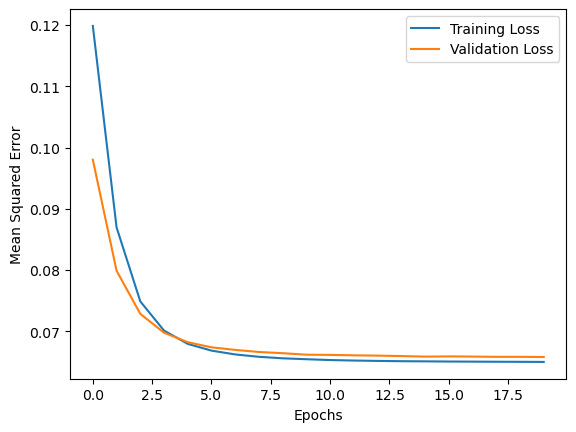

13/13 [==============================] - 1s 48ms/step
Best model MSE on test data =  0.06686337


In [9]:
import tensorflow as tf
import keras
from keras.layers import Dense, Flatten
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.losses import MeanSquaredError

# hyperparameters
INPUT_SIZE = (X.shape[1], X.shape[2], 1)
EPOCHS = 20
BATCH_SIZE = 128
DROPOUT = 0.10
ACTIVATION = 'sigmoid'
lr = 0.20

#Create model
model = Sequential()
model.add(Flatten())
model.add(Dense(1560, activation=ACTIVATION))
model.add(Dense(2048, activation=ACTIVATION))
model.add(Dense(4096, activation=ACTIVATION))
model.add(Dense(8192, activation=ACTIVATION))
model.add(Dense(4096, activation=ACTIVATION))
model.add(Dense(2048, activation=ACTIVATION))
model.add(Dense(1024, activation=ACTIVATION))
model.add(Dense(512, activation=ACTIVATION))
model.add(Dense(256, activation=ACTIVATION))
model.add(Dense(128, activation=ACTIVATION))
model.add(Dense(64, activation=ACTIVATION))
model.add(Dense(32, activation=ACTIVATION))
model.add(Dense(13, activation=ACTIVATION))

mse = MeanSquaredError()
adam = optimizers.Adam(learning_rate=lr, decay=1e-3)
model.compile(optimizer=adam, loss=mse, metrics = None)

filepath = 'models/ff/best_ff.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint]

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

data = X.reshape(X.shape[0],X.shape[1], X.shape[2])

history = model.fit(data, y, batch_size=BATCH_SIZE, epochs=EPOCHS,
                  validation_split=0.2,
                  callbacks=callbacks)

#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('images/ff_training_history')
plt.show()

#Load and evaluate the best model version
model = load_model(filepath)
yhat = model.predict(X_test)
print('Best model MSE on test data = ', mse(y_test, yhat).numpy())

In [94]:
tracks = pd.read_csv('src/tracks_features.csv')
tracks = tracks[['id', 'name', 'album', 'artists']]

In [95]:
filtered = tracks[tracks['name'] == 'So What']
# filtered = filtered[filtered['album'] == 'Kind of Blue']
my_artist = 'Miles Davis'
filtered['right artist'] = filtered['artists'].apply(lambda row: 1 if my_artist in row else 0)
filtered = filtered[filtered['right artist'] == 1]
filtered.head(10)

/var/folders/jc/l8gc1q891rl5rcv8zg4yjywm0000gn/T/ipykernel_42389/2862184830.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['right artist'] = filtered['artists'].apply(lambda row: 1 if my_artist in row else 0)


,id,name,album,artists,right artist
343923,7rsrrtdmzBv09v3dspuq5M,So What,The Best Of Ken Burns Jazz,['Miles Davis'],1
657801,0LcbNWzkAnC0BASstAjzSf,So What,Jazz: The Definitive Performances,['Miles Davis'],1
856381,3mZ33QYHWylbabTz82rHwj,So What,Pleasantville -Music From The Motion Picture,['Miles Davis'],1
1190552,4vLYewWIvqHfKtJDk8c8tq,So What,Kind Of Blue (Legacy Edition),['Miles Davis'],1


In [96]:
my_track = '4vLYewWIvqHfKtJDk8c8tq'
data = pd.read_pickle('crafted_data/playlists_and_trackid_start0_end7400.pkl')
data['num_tracks_id'] = data['tracks'].apply(lambda row: len(row))
data = data[data['num_tracks_id'] >= 10]
my_playlists = data.copy()
my_playlists['interest'] = my_playlists['tracks'].apply(lambda row: 1 if my_track in row else 0)

In [97]:
my_playlists = my_playlists[my_playlists['interest'] == 1]
print(my_playlists.shape)
my_playlists.head(my_playlists.shape[0])

(5, 6)


,pid,name,tracks,num_tracks,num_tracks_id,interest
83,2083,chill,"[3z0kLcBMR7fzsYjfrtWFf2, 1YVc2NJBwOtAebQiSUbt5...",100,29,1
128,4128,Gold,"[2wBf6PGWOMrrAykBmxIF9X, 75Bf3tD7wCLxIc3C6GCER...",213,42,1
490,5490,Thanksgiving,"[5wL742yBgvtbw1IibA3FMJ, 70UB5GwrRIDLfAHiQttyk...",62,21,1
815,6815,JAZZ,"[0PHqHvmg4TIaANfbsvDMTR, 4mh17mzDplLjImZg1I3iv...",179,39,1
259,7259,ENgagement party,"[6q0lIjDSuZDhrg9GC9yUQO, 5qGavrnGfH766WNp5pZXS...",36,11,1


In [98]:
my_playlist = X[82].reshape(1, X[82].shape[0], X[82].shape[1], 1)
next_song = model.predict(my_playlist)
print(next_song)


1/1 [==============================] - 0s 145ms/step
[[0.18759918 0.5829484  0.60325867 0.47410673 0.7637756  0.6750995
  0.11136349 0.2835892  0.09759691 0.18628606 0.4880336  0.48609018
  0.78368264]]


In [99]:
def reverseScale(song):
    curr = np.ndarray((13,), dtype=np.float16)
    # explicit
    curr[0] = np.round(song.squeeze()[0])
    # danceability 1
    curr[1] = song.squeeze()[1]
    # energy 2
    curr[2] = song.squeeze()[2]
    # key 3
    curr[3] = int(song.squeeze()[3] * 11)
    # loudness 4
    loud_range = 7.234 - (-60.0)
    curr[4] = song.squeeze()[4] * loud_range + (-60.0)
    # mode 5
    curr[5] = np.round(song.squeeze()[5])
    # speechiness 6 range: from 0.0 to 0.969
    speech_range = (0.969) - (0.0)
    curr[6] = song.squeeze()[6] * speech_range + (0.0)
    # acousticness 7 range: from 0.0 to 0.996
    acoustic_range = 0 - (0.996)
    curr[7] = song.squeeze()[7] * acoustic_range + (0.0)
    # instrumentalness 8 range: from 0.0 to 1.0
    instrumental_range = (1.0) - (0.0)
    curr[8] = song.squeeze()[8] * instrumental_range + (0.0)
    # liveness 9 range: from 0.0 to 1.0
    live_range = (1.0) - (0.0)
    curr[9] = song.squeeze()[9] * live_range + (0.0)
    # valence 10 range: from 0.0 to 1.0
    val_range = (1.0) - (0.0)
    curr[10] = song.squeeze()[10] * val_range + (0.0)
    # tempo 11 range: from 0.0 to 248.93400000000003
    tempo_range = (248.93400000000003) - (0)
    curr[11] = song.squeeze()[11] * tempo_range + (0.0)
    # time_signature 12 range: from 0.0 to 5.0
    time_range = (5.0) - (0)
    curr[12] = np.round(song.squeeze()[12] * time_range + (0.0), 0)
    return curr

In [100]:
fixed = reverseScale(next_song)

In [101]:
print(fixed)

[ 0.000e+00  5.830e-01  6.030e-01  5.000e+00 -8.648e+00  1.000e+00
  1.079e-01 -2.825e-01  9.760e-02  1.863e-01  4.880e-01  1.210e+02
  4.000e+00]
